# 📘 Week 3: Water Segmentation using Multispectral and Optical Data


In [127]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.7 MB/s eta 0:00:0000:0100:01


In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

# For data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# For image processing
from skimage import filters, exposure
from scipy.ndimage import gaussian_filter
import rasterio
from rasterio.plot import show

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [129]:
# Configuration
class Config:
    # Paths
    DATA_PATH = '/kaggle/input/water-segmentation11/data'
    IMAGE_PATH = os.path.join(DATA_PATH, 'images')
    LABEL_PATH = os.path.join(DATA_PATH, 'labels')
    
    # Image properties
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    N_CHANNELS = 12
    N_CLASSES = 1  # Binary segmentation
    
    # Training parameters
    BATCH_SIZE = 16
    EPOCHS = 100
    LEARNING_RATE = 1e-4
    
    # Data split ratios
    TRAIN_RATIO = 0.8
    VAL_RATIO = 0.1
    TEST_RATIO = 0.1
    
    # Random seed for reproducibility
    RANDOM_SEED = 42

config = Config()
tf.random.set_seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

In [130]:
def load_tif_image(image_path):
    """Load multispectral TIF image with all bands"""
    try:
        # Try with rasterio first (better for multispectral data)
        with rasterio.open(image_path) as src:
            # Read all bands
            img = src.read()  # Shape: (bands, height, width)
            # Transpose to (height, width, bands)
            img = np.transpose(img, (1, 2, 0))
            return img.astype(np.float32)
    except:
        # Fallback to cv2
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        return img.astype(np.float32)

def load_mask(mask_path):
    """Load binary mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Ensure binary values (0 or 1)
    mask = (mask > 0).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

def normalize_multispectral(image):
    """Normalize each band separately"""
    normalized = np.zeros_like(image)
    for i in range(image.shape[-1]):
        band = image[:, :, i]
        # Percentile-based normalization for robustness
        p2, p98 = np.percentile(band, (2, 98))
        normalized[:, :, i] = np.clip((band - p2) / (p98 - p2 + 1e-8), 0, 1)
    return normalized

def get_data_pairs():
    """Get all image-mask pairs"""
    image_files = sorted([f for f in os.listdir(config.IMAGE_PATH) if f.endswith('.tif')])
    data_pairs = []
    
    for img_file in image_files:
        # Extract base name (e.g., '0' from '0.tif')
        base_name = os.path.splitext(img_file)[0]
        mask_file = f"{base_name}.png"
        
        img_path = os.path.join(config.IMAGE_PATH, img_file)
        mask_path = os.path.join(config.LABEL_PATH, mask_file)
        
        if os.path.exists(mask_path):
            data_pairs.append((img_path, mask_path))
    
    return data_pairs

# Get all data pairs
data_pairs = get_data_pairs()
print(f"Total number of image-mask pairs: {len(data_pairs)}")

Total number of image-mask pairs: 306


Image shape: (128, 128, 12)
Mask shape: (128, 128, 1)
Image data range: [-28.00, 4975.00]
Unique mask values: [0. 1.]


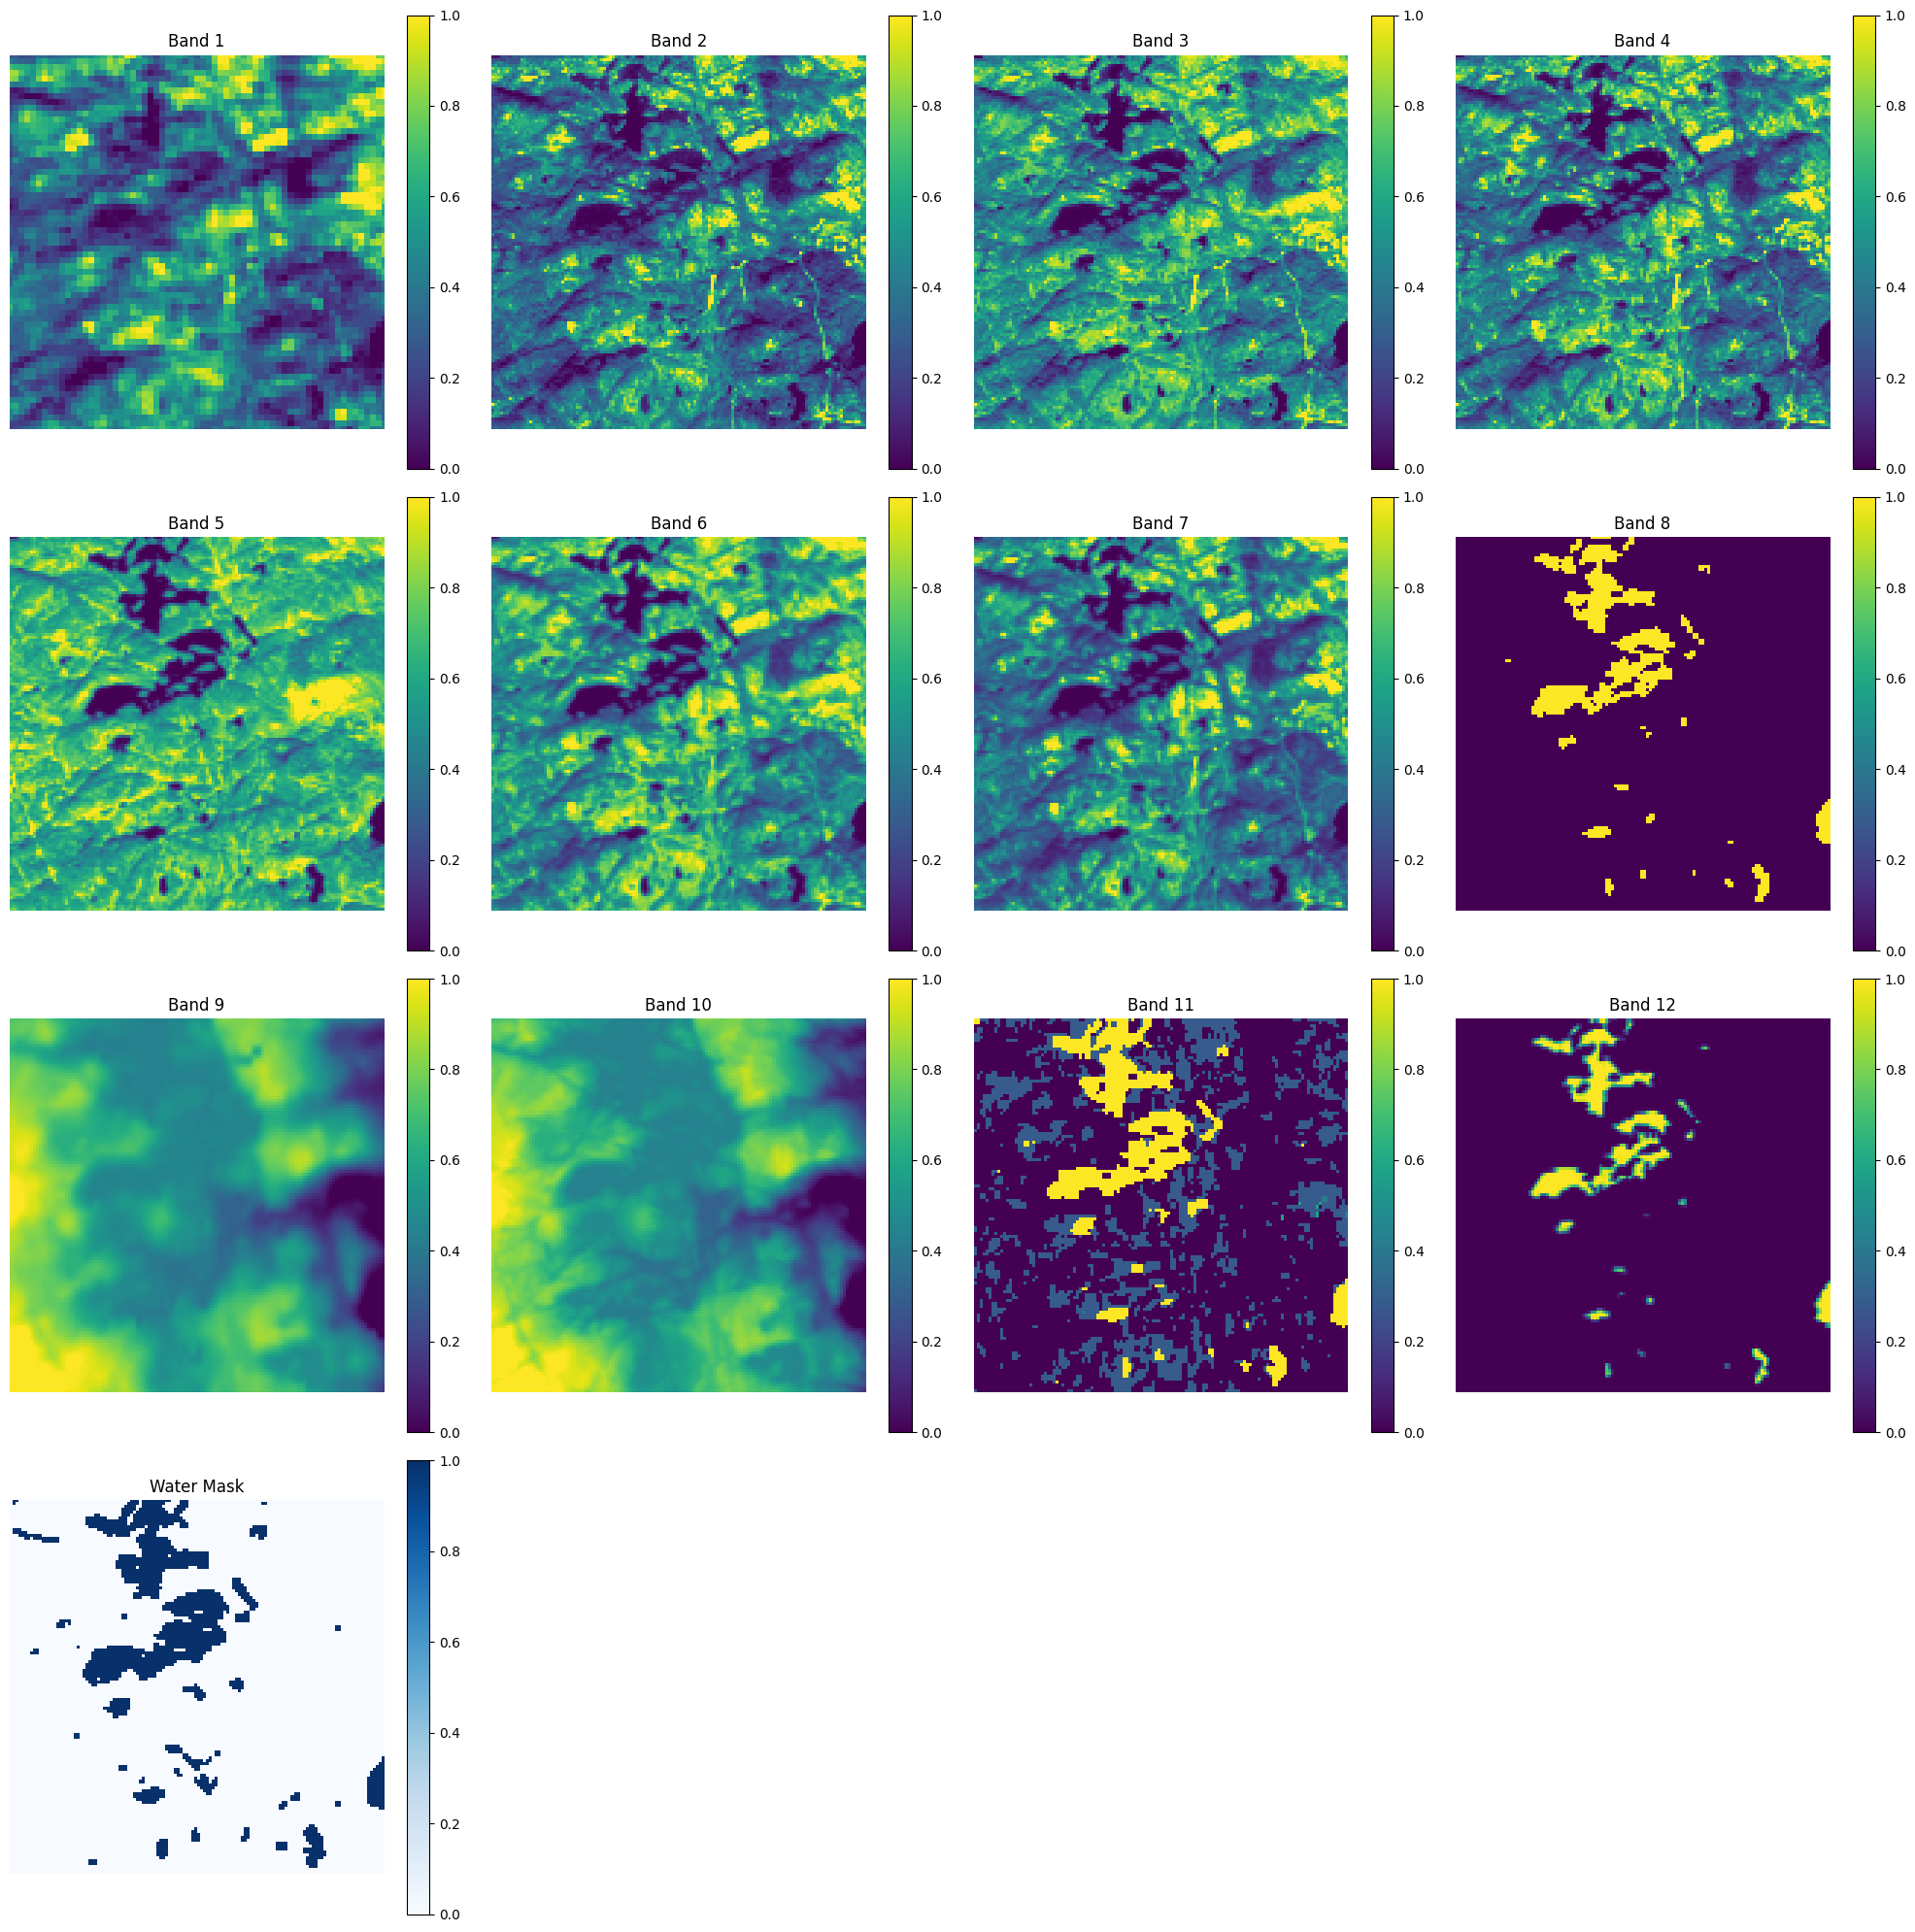

In [131]:
def visualize_sample_with_bands(image_path, mask_path, sample_idx=0):
    """Visualize all bands of a sample image and its mask"""
    # Load data
    image = load_tif_image(image_path)
    mask = load_mask(mask_path)
    
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Image data range: [{image.min():.2f}, {image.max():.2f}]")
    print(f"Unique mask values: {np.unique(mask)}")
    
    # Normalize for visualization
    image_norm = normalize_multispectral(image)
    
    # Plot all bands
    n_bands = image.shape[-1]
    cols = 4
    rows = (n_bands + cols - 1) // cols + 1  # +1 for mask
    
    plt.figure(figsize=(20, 5 * rows))
    
    # Plot each band
    for i in range(n_bands):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_norm[:, :, i], cmap='viridis')
        plt.title(f'Band {i+1}')
        plt.colorbar()
        plt.axis('off')
    
    # Plot mask
    plt.subplot(rows, cols, n_bands + 1)
    plt.imshow(mask[:, :, 0], cmap='Blues')
    plt.title('Water Mask')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize first sample
if len(data_pairs) > 0:
    visualize_sample_with_bands(data_pairs[0][0], data_pairs[0][1])

Analyzing band correlations: 100%|██████████| 50/50 [00:00<00:00, 81.83it/s]


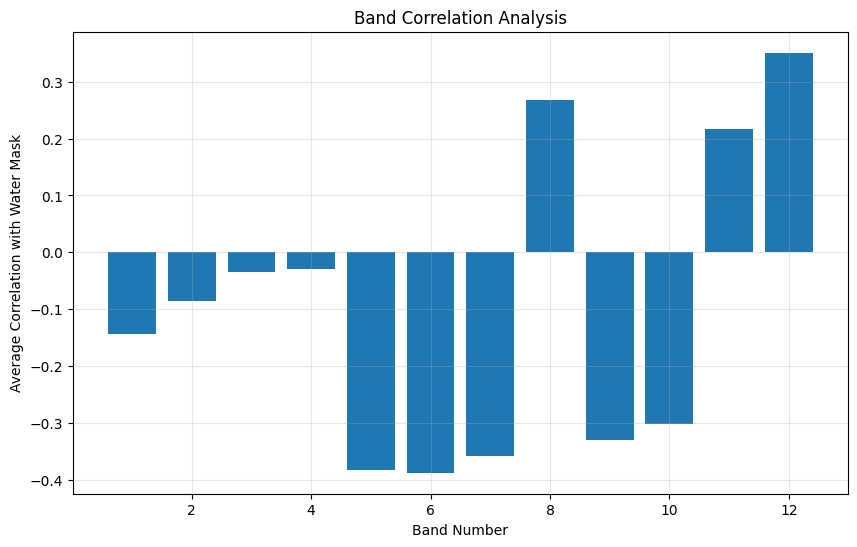

In [132]:
def analyze_band_correlation(data_pairs, n_samples=50):
    """Analyze correlation between bands and water mask"""
    n_samples = min(n_samples, len(data_pairs))
    sample_indices = np.random.choice(len(data_pairs), n_samples, replace=False)
    
    band_correlations = []
    
    for idx in tqdm(sample_indices, desc="Analyzing band correlations"):
        img_path, mask_path = data_pairs[idx]
        image = load_tif_image(img_path)
        mask = load_mask(mask_path)
        
        # Normalize image
        image_norm = normalize_multispectral(image)
        
        # Calculate correlation for each band
        for band_idx in range(image.shape[-1]):
            band = image_norm[:, :, band_idx].flatten()
            mask_flat = mask.flatten()
            if np.std(mask_flat) > 0:  # Only if mask has variation
                corr = np.corrcoef(band, mask_flat)[0, 1]
                band_correlations.append(corr)
            else:
                band_correlations.append(0)
    
    # Reshape and average correlations
    band_correlations = np.array(band_correlations).reshape(-1, config.N_CHANNELS)
    avg_correlations = np.mean(band_correlations, axis=0)
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, config.N_CHANNELS + 1), avg_correlations)
    plt.xlabel('Band Number')
    plt.ylabel('Average Correlation with Water Mask')
    plt.title('Band Correlation Analysis')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return avg_correlations

# Analyze band correlations
correlations = analyze_band_correlation(data_pairs)

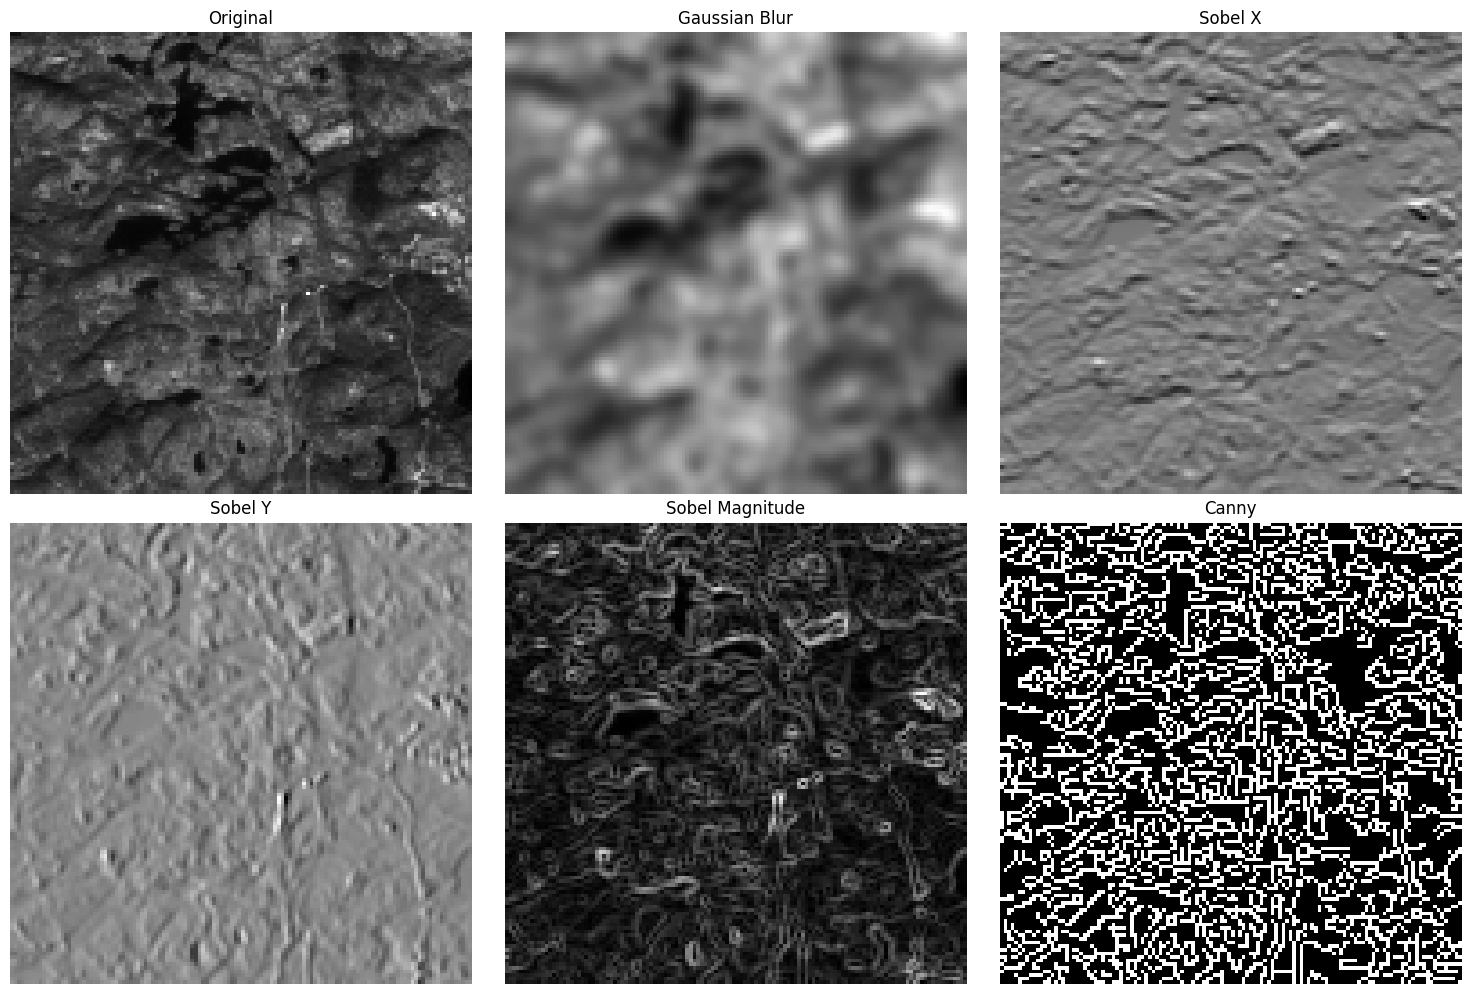

In [133]:
def apply_edge_filters(image):
    """Apply various edge detection filters"""
    # Select a representative band (e.g., band with highest correlation)
    band_idx = 3  # You can change this based on correlation analysis
    band = image[:, :, band_idx]
    
    # Normalize band
    band_norm = (band - band.min()) / (band.max() - band.min() + 1e-8)
    
    # Apply filters
    filters_dict = {
        'Original': band_norm,
        'Gaussian Blur': gaussian_filter(band_norm, sigma=2),
        'Sobel X': filters.sobel_h(band_norm),
        'Sobel Y': filters.sobel_v(band_norm),
        'Sobel Magnitude': filters.sobel(band_norm),
        'Canny': cv2.Canny((band_norm * 255).astype(np.uint8), 50, 150) / 255.0
    }
    
    # Visualize filters
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (name, filtered) in enumerate(filters_dict.items()):
        axes[idx].imshow(filtered, cmap='gray')
        axes[idx].set_title(name)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return filters_dict

# Apply filters to first sample
if len(data_pairs) > 0:
    sample_image = load_tif_image(data_pairs[0][0])
    edge_filters = apply_edge_filters(sample_image)

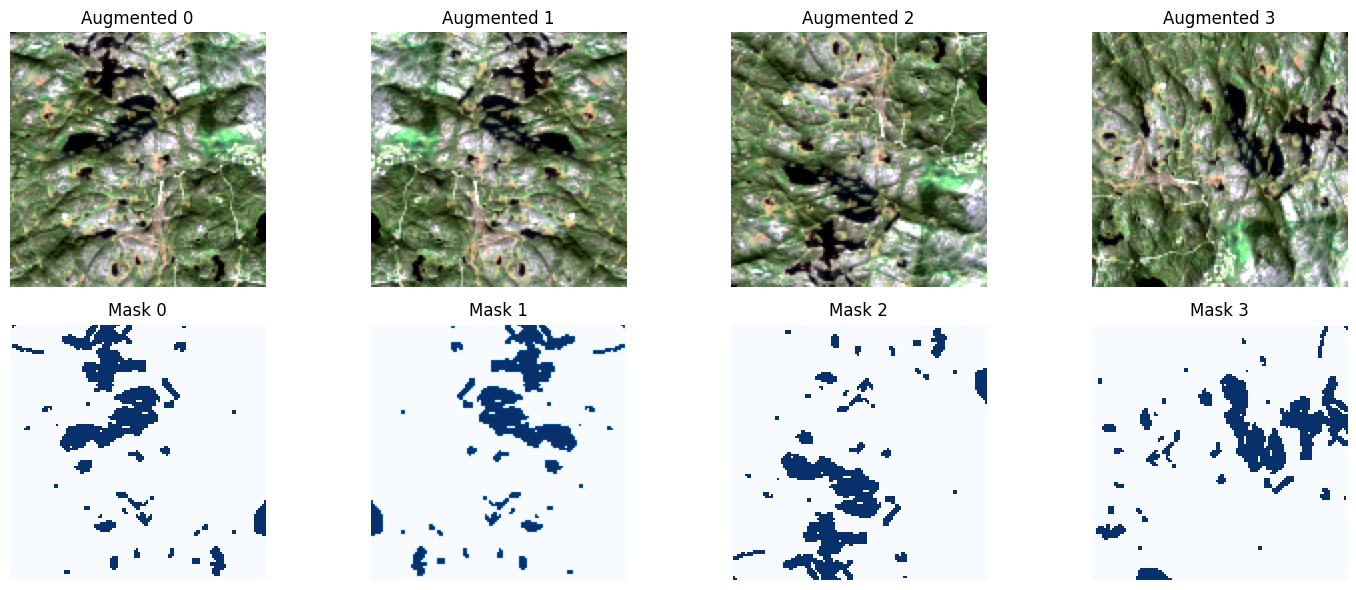

In [134]:
def augment_data(image, mask):
    """Apply augmentation to image and mask pairs"""
    augmented_pairs = [(image, mask)]  # Original
    
    # Random horizontal flip
    if np.random.random() > 0.5:
        aug_img = np.fliplr(image)
        aug_mask = np.fliplr(mask)
        augmented_pairs.append((aug_img, aug_mask))
    
    # Random vertical flip
    if np.random.random() > 0.5:
        aug_img = np.flipud(image)
        aug_mask = np.flipud(mask)
        augmented_pairs.append((aug_img, aug_mask))
    
    # Random rotation (90, 180, 270 degrees)
    if np.random.random() > 0.5:
        k = np.random.randint(1, 4)
        aug_img = np.rot90(image, k)
        aug_mask = np.rot90(mask, k)
        augmented_pairs.append((aug_img, aug_mask))
    
    # Random brightness adjustment
    if np.random.random() > 0.5:
        brightness_factor = np.random.uniform(0.8, 1.2)
        aug_img = np.clip(image * brightness_factor, 0, 1)
        augmented_pairs.append((aug_img, mask))
    
    # Random noise
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 0.01, image.shape)
        aug_img = np.clip(image + noise, 0, 1)
        augmented_pairs.append((aug_img, mask))
    
    return augmented_pairs

def visualize_augmentations(image_path, mask_path):
    """Visualize augmented samples"""
    image = load_tif_image(image_path)
    mask = load_mask(mask_path)
    
    # Normalize image
    image_norm = normalize_multispectral(image)
    
    # Get augmented pairs
    augmented = augment_data(image_norm, mask)
    
    # Visualize RGB composite for better visualization
    fig, axes = plt.subplots(2, len(augmented), figsize=(15, 6))
    
    for idx, (aug_img, aug_mask) in enumerate(augmented):
        # Create RGB composite using bands 3, 2, 1 (adjust as needed)
        rgb = np.stack([aug_img[:,:,3], aug_img[:,:,2], aug_img[:,:,1]], axis=-1)
        rgb = np.clip(rgb, 0, 1)
        
        # Plot image
        axes[0, idx].imshow(rgb)
        axes[0, idx].set_title(f'Augmented {idx}')
        axes[0, idx].axis('off')
        
        # Plot mask
        axes[1, idx].imshow(aug_mask[:,:,0], cmap='Blues')
        axes[1, idx].set_title(f'Mask {idx}')
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize augmentations
if len(data_pairs) > 0:
    visualize_augmentations(data_pairs[0][0], data_pairs[0][1])

In [135]:
class MultispectralDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for multispectral images"""
    
    def __init__(self, data_pairs, batch_size=16, shuffle=True, augment=False):
        self.data_pairs = data_pairs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.data_pairs))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.data_pairs) / self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_pairs = [self.data_pairs[i] for i in batch_indices]
        
        # Generate batch
        X, y = self.__data_generation(batch_pairs)
        return X, y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.data_pairs))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, batch_pairs):
        # Initialize batch arrays
        X = []
        y = []
        
        for img_path, mask_path in batch_pairs:
            # Load image and mask
            image = load_tif_image(img_path)
            mask = load_mask(mask_path)
            
            # Normalize image
            image = normalize_multispectral(image)
            
            # Apply augmentation if enabled
            if self.augment:
                aug_pairs = augment_data(image, mask)
                # Randomly select one augmentation
                image, mask = aug_pairs[np.random.randint(len(aug_pairs))]
            
            X.append(image)
            y.append(mask)
        
        return np.array(X), np.array(y)

In [148]:
# Split data into train, validation, and test sets
train_pairs, test_pairs = train_test_split(
    data_pairs, 
    test_size=(config.VAL_RATIO + config.TEST_RATIO), 
    random_state=config.RANDOM_SEED
)

val_pairs, test_pairs = train_test_split(
    test_pairs, 
    test_size=config.TEST_RATIO / (config.VAL_RATIO + config.TEST_RATIO), 
    random_state=config.RANDOM_SEED
)

print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")
print(f"Test samples: {len(test_pairs)}")

# Create data generators
train_generator = MultispectralDataGenerator(
    train_pairs, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    augment=True
)

val_generator = MultispectralDataGenerator(
    val_pairs, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    augment=False
)

test_generator = MultispectralDataGenerator(
    test_pairs, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    augment=False
)

Training samples: 244
Validation samples: 31
Test samples: 31


In [137]:
def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    """Convolutional block with batch normalization"""
    x = layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def build_unet(input_shape=(128, 128, 12), n_classes=1):
    """Build U-Net model for multispectral segmentation"""
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    # Block 1
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = conv_block(pool4, 1024)
    
    # Decoder
    # Block 6
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv4])
    conv6 = conv_block(concat6, 512)
    
    # Block 7
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv3])
    conv7 = conv_block(concat7, 256)
    
    # Block 8
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv2])
    conv8 = conv_block(concat8, 128)
    
    # Block 9
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = layers.concatenate([up9, conv1])
    conv9 = conv_block(concat9, 64)
    
    # Output layer
    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = build_unet(
    input_shape=(config.IMG_HEIGHT, config.IMG_WIDTH, config.N_CHANNELS),
    n_classes=config.N_CLASSES
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_27[0][0] 

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [138]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for binary segmentation"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for optimization"""
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """Intersection over Union metric"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(y_true, y_pred):
    """Combined binary crossentropy and dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=combined_loss,
    metrics=[
        'accuracy',
        dice_coefficient,
        iou_metric,
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [139]:
# Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        'best_water_segmentation_model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=5,
        mode='max',
        min_lr=1e-7,
        verbose=1
    )
]

In [140]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1752786497.987815     334 service.cc:148] XLA service 0x79709c0483f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752786497.989023     334 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752786499.864973     334 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/16 ━━━━━━━━━━━━━━━━━━━━ 9:28 38s/step - accuracy: 0.2411 - dice_coefficient: 0.3429 - iou_metric: 0.2069 - loss: 2.0995 - precision: 0.2143 - recall: 0.9803

I0000 00:00:1752786516.884160     334 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.2811 - dice_coefficient: 0.3810 - iou_metric: 0.2411 - loss: 1.8930 - precision: 0.2388 - recall: 0.9722

E0000 00:00:1752786522.365932     335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752786522.599548     335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3290 - dice_coefficient: 0.4138 - iou_metric: 0.2676 - loss: 1.7464 - precision: 0.2639 - recall: 0.9606

E0000 00:00:1752786539.396711     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752786539.633892     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_dice_coefficient improved from -inf to 0.34983, saving model to best_water_segmentation_model.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.3358 - dice_coefficient: 0.4173 - iou_metric: 0.2705 - loss: 1.7292 - precision: 0.2671 - recall: 0.9591 - val_accuracy: 0.6783 - val_dice_coefficient: 0.3498 - val_iou_metric: 0.2125 - val_loss: 1.3215 - val_precision: 0.4194 - val_recall: 0.8113 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7649 - dice_coefficient: 0.5342 - iou_metric: 0.3707 - loss: 1.0067 - precision: 0.5451 - recall: 0.8062
Epoch 2: val_dice_coefficient improved from 0.34983 to 0.37038, saving model to best_water_segmentation_model.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.7671 - dice_coefficient: 0.5339 - iou_metric: 0.3707 - loss: 1.0039 - precision: 0.5485 - recall: 0.8046 - val_accuracy: 0.8697 - val_dice_coefficient: 0.3704 - val_iou_metric: 0.2278 - val_loss: 1.2623 - val_precision: 

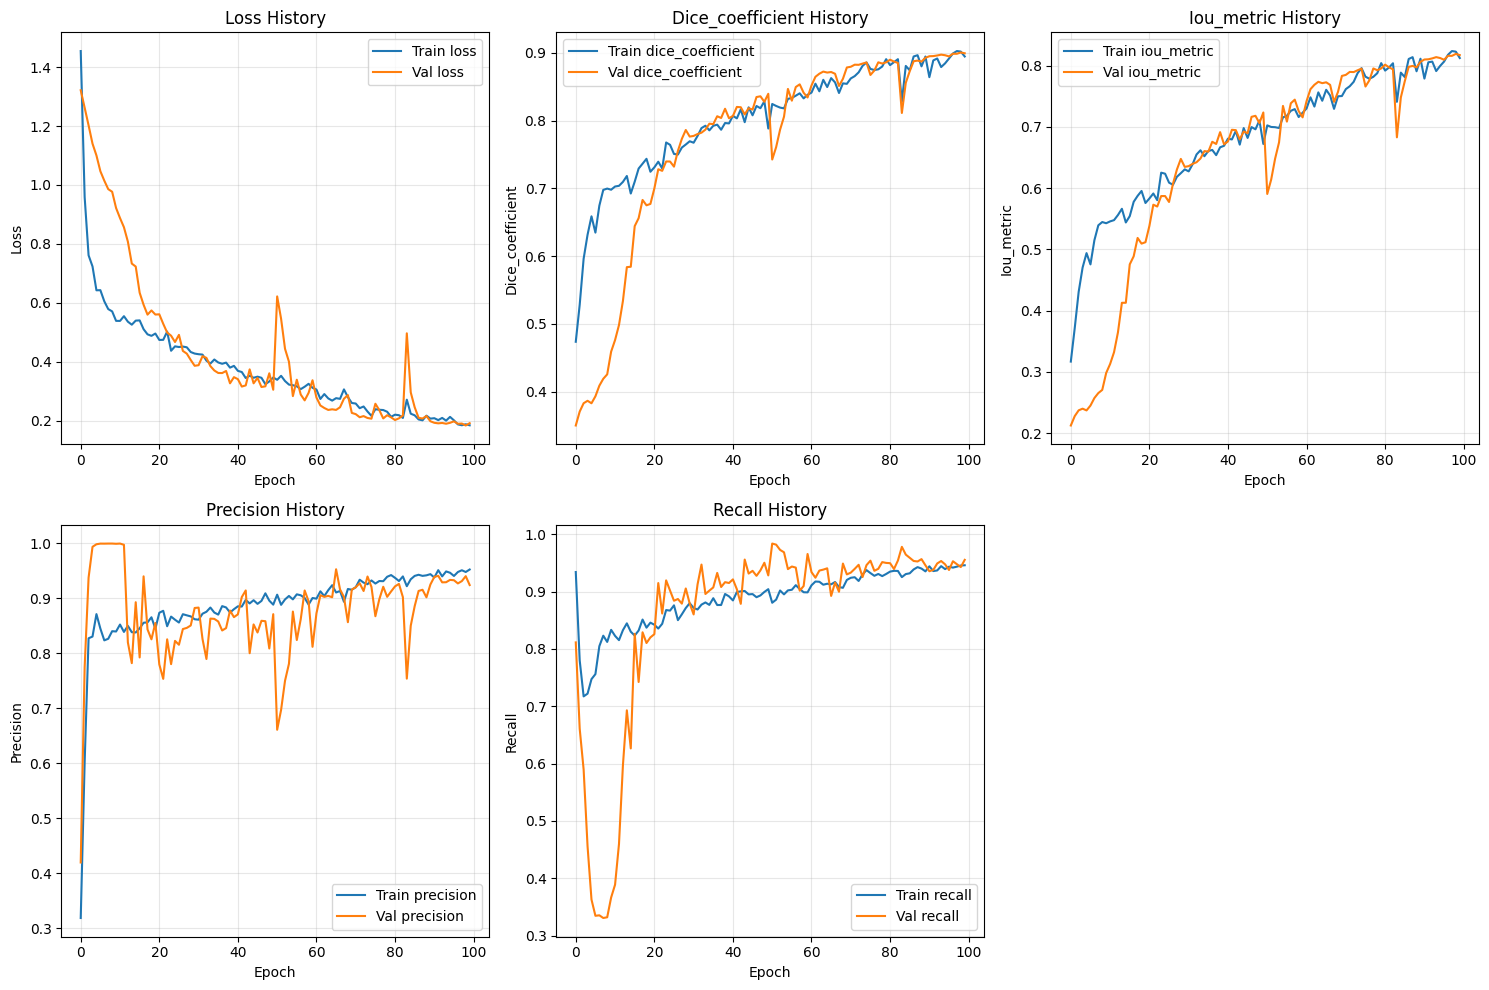

In [141]:
def plot_training_history(history):
    """Plot training metrics"""
    metrics = ['loss', 'dice_coefficient', 'iou_metric', 'precision', 'recall']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Train {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        axes[idx].set_title(f'{metric.capitalize()} History')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    # Remove extra subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [142]:
def evaluate_model(model, test_generator):
    """Evaluate model on test set"""
    # Get predictions
    predictions = []
    ground_truths = []
    
    for i in range(len(test_generator)):
        X_batch, y_batch = test_generator[i]
        pred_batch = model.predict(X_batch, verbose=0)
        
        predictions.extend(pred_batch)
        ground_truths.extend(y_batch)
    
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)
    
    # Calculate metrics
    test_loss, test_acc, test_dice, test_iou, test_prec, test_recall = model.evaluate(
        test_generator, 
        verbose=1
    )
    
    print("\n=== Test Set Performance ===")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Dice Coefficient: {test_dice:.4f}")
    print(f"IoU: {test_iou:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-Score: {2 * (test_prec * test_recall) / (test_prec + test_recall + 1e-8):.4f}")
    
    return predictions, ground_truths

# Evaluate model
predictions, ground_truths = evaluate_model(model, test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9682 - dice_coefficient: 0.8649 - iou_metric: 0.7623 - loss: 0.2329 - precision: 0.9233 - recall: 0.9169

=== Test Set Performance ===
Loss: 0.2279
Accuracy: 0.9687
Dice Coefficient: 0.8702
IoU: 0.7706
Precision: 0.9260
Recall: 0.9196
F1-Score: 0.9228


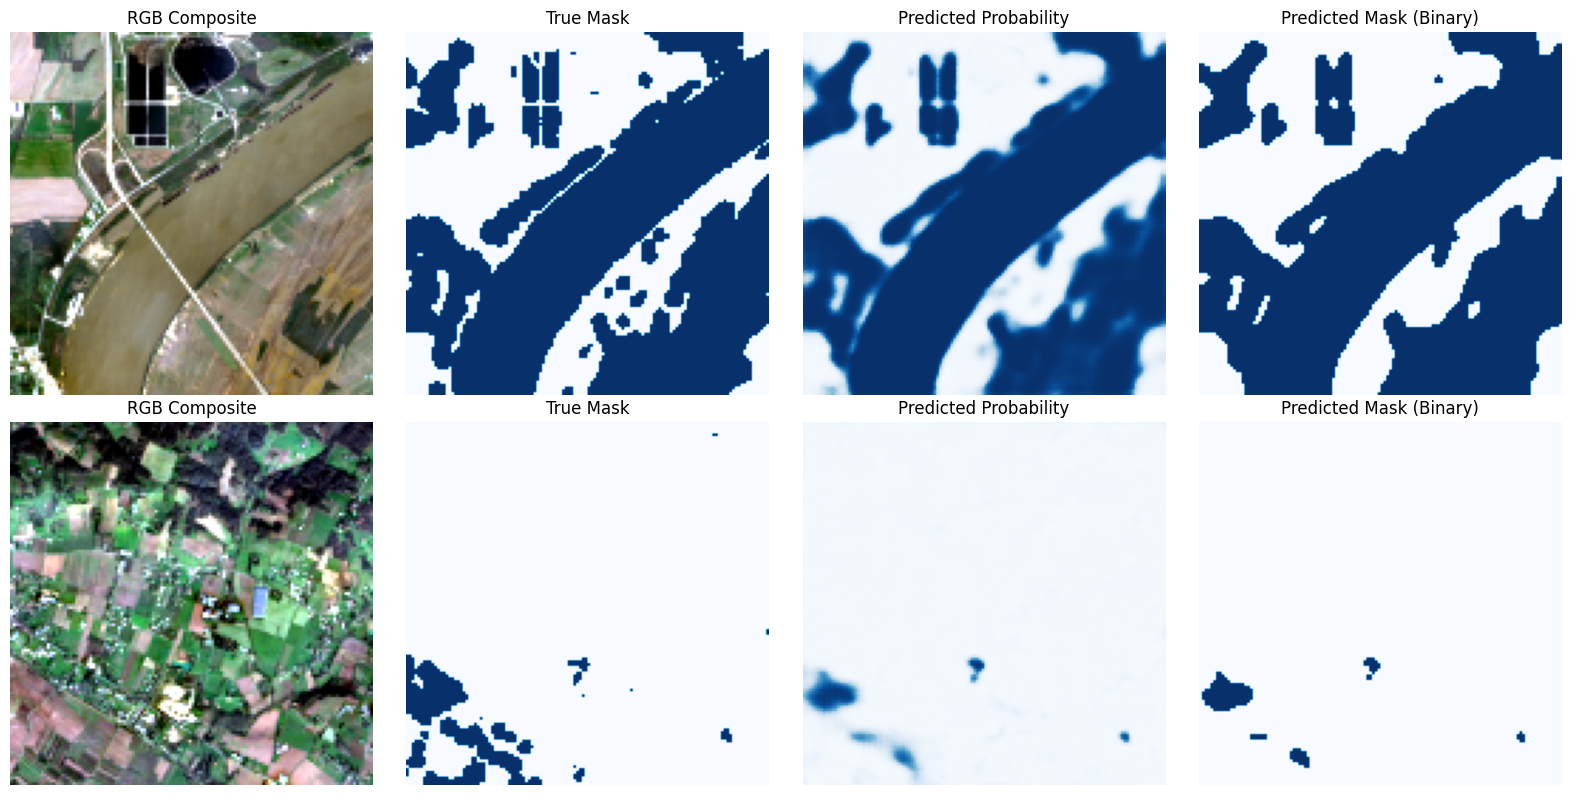

In [150]:
def visualize_predictions(test_generator, model, n_samples=5):
    """Visualize model predictions"""
    # Get random samples
    sample_indices = np.random.choice(len(test_generator), min(n_samples, len(test_generator)), replace=False)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(sample_indices):
        X_batch, y_batch = test_generator[sample_idx]
        
        # Take first image from batch
        image = X_batch[0]
        true_mask = y_batch[0]
        
        # Predict
        pred_mask = model.predict(np.expand_dims(image, 0), verbose=0)[0]
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
        
        # Create RGB composite for visualization
        rgb = np.stack([image[:,:,3], image[:,:,2], image[:,:,1]], axis=-1)
        rgb = np.clip(rgb, 0, 1)
        
        # Plot
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title('RGB Composite')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(true_mask[:,:,0], cmap='Blues')
        axes[idx, 1].set_title('True Mask')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_mask[:,:,0], cmap='Blues', vmin=0, vmax=1)
        axes[idx, 2].set_title('Predicted Probability')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(pred_mask_binary[:,:,0], cmap='Blues')
        axes[idx, 3].set_title('Predicted Mask (Binary)')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(test_generator, model, n_samples=2)

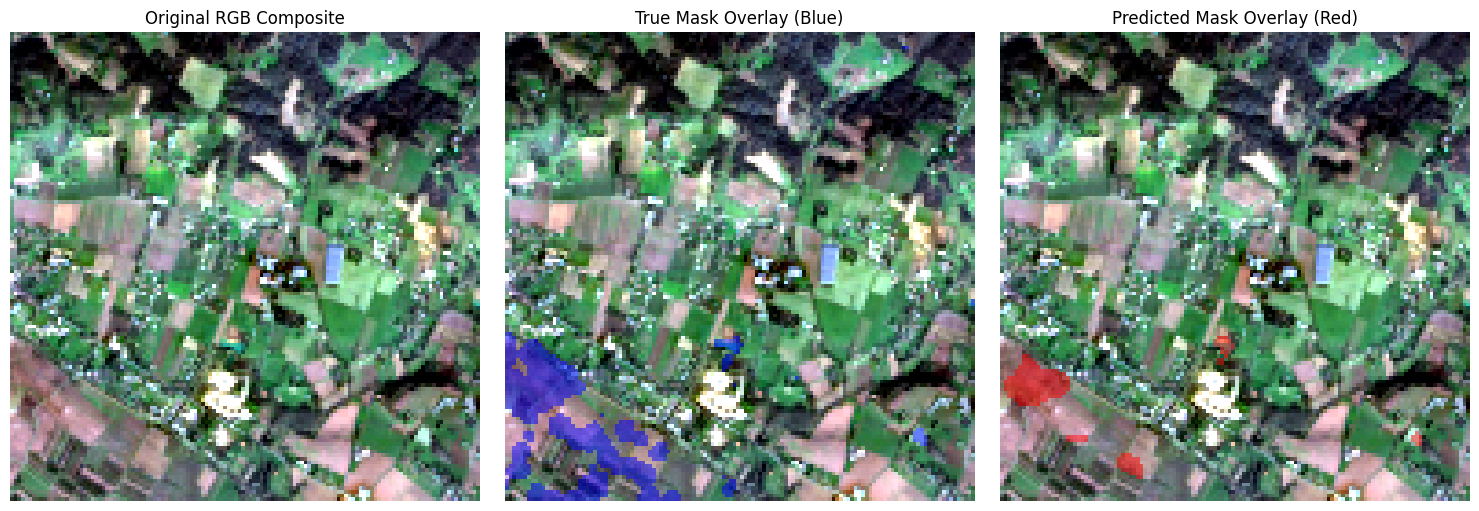

In [145]:
def create_overlay_visualization(image, true_mask, pred_mask, alpha=0.5):
    """Create overlay visualization of predictions"""
    # Create RGB composite
    rgb = np.stack([image[:,:,3], image[:,:,2], image[:,:,1]], axis=-1)
    rgb = np.clip(rgb, 0, 1)
    
    # Create colored masks
    true_colored = np.zeros((*true_mask.shape[:2], 3))
    true_colored[:,:,2] = true_mask[:,:,0]  # Blue for true
    
    pred_colored = np.zeros((*pred_mask.shape[:2], 3))
    pred_colored[:,:,0] = pred_mask[:,:,0]  # Red for predicted
    
    # Create overlays
    overlay_true = rgb.copy()
    mask_indices = true_mask[:,:,0] > 0
    overlay_true[mask_indices] = alpha * true_colored[mask_indices] + (1-alpha) * rgb[mask_indices]
    
    overlay_pred = rgb.copy()
    mask_indices = pred_mask[:,:,0] > 0
    overlay_pred[mask_indices] = alpha * pred_colored[mask_indices] + (1-alpha) * rgb[mask_indices]
    
    return rgb, overlay_true, overlay_pred

# Create advanced visualization
X_sample, y_sample = test_generator[0]
pred_sample = model.predict(X_sample[:1], verbose=0)
pred_binary = (pred_sample[0] > 0.5).astype(np.float32)

rgb, overlay_true, overlay_pred = create_overlay_visualization(
    X_sample[0], y_sample[0], pred_binary
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb)
axes[0].set_title('Original RGB Composite')
axes[0].axis('off')

axes[1].imshow(overlay_true)
axes[1].set_title('True Mask Overlay (Blue)')
axes[1].axis('off')

axes[2].imshow(overlay_pred)
axes[2].set_title('Predicted Mask Overlay (Red)')
axes[2].axis('off')

plt.tight_layout()
plt.show()